In [1]:
from ml_config import *
from jw_package import *
pd.options.mode.chained_assignment = None

import configuration completed !
train + key + weather merging started
train + key + weather merging finished
function configuration completed ! 
Good to go !


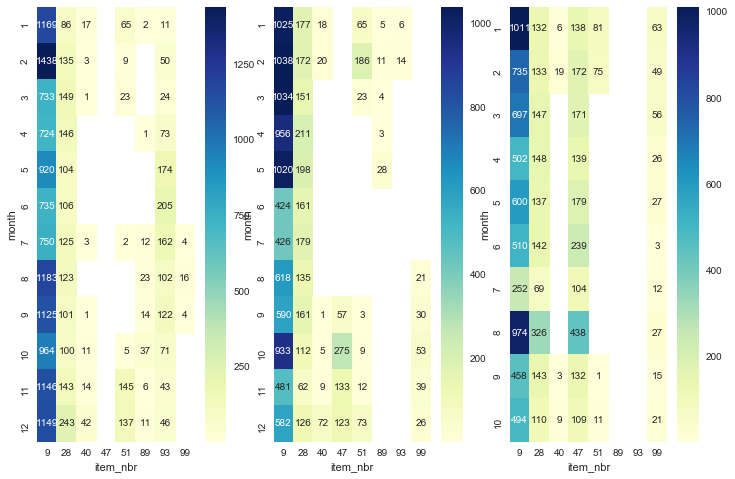

In [2]:
item_nbr_tendency(1)

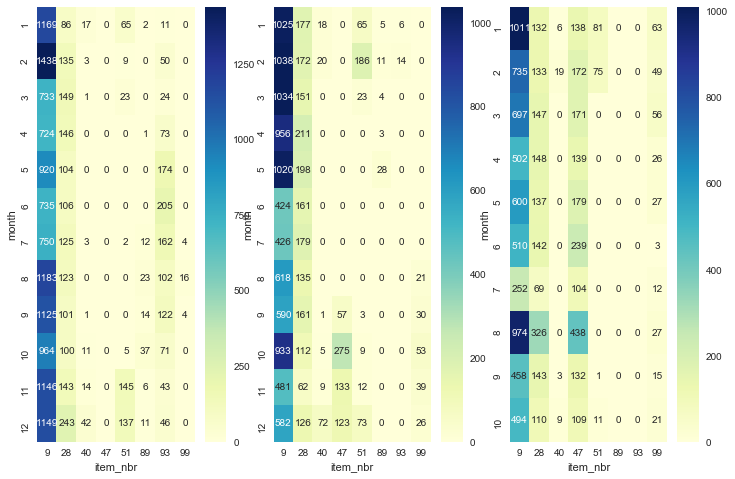

In [2]:
item_nbr_tendency(1)

In [16]:
def missing_to_nan_weather(station_nbr):
    print('missing_to_nan started !')
    
    full_weather = load_weather()
    
    full_weather = full_weather[full_weather['station_nbr']==station_nbr]
    
    # sunrise, sunset, category는 연속형변수가 아니므로 일단 뺌
    weathers = set(list(full_weather.columns)[2:20])
    targets = weathers - {'sunset','sunrise','codesum'}
    
    def trim_str(x):
        import re
                            # 실수만 추출
        result = re.findall('(\d+(?:\.\d+)?)',x)
        if result:
            return float(result[0])
        return np.nan
    
    for weather in targets:
        full_weather.loc[:,weather] = full_weather.loc[:,weather].astype(str).apply(trim_str).astype(float)
    
    print('missing_to_nan completed !')
    return full_weather.reset_index(drop=True)

In [17]:
def how_many_missing(nan_weather):
    
    weathers = set(list(nan_weather.columns)[2:20])
    targets = weathers - {'sunset','sunrise','codesum'}
    
    how_many = dict()
    total = len(nan_weather)
    
    for weather in targets:
        not_missing = len(nan_weather[weather].dropna())
    
        msg = 'total = '+ str(total) +' '
        msg += ', missing = '+ str(total - not_missing)
        
        how_many[weather] = msg
    
    return how_many

In [18]:
def all_missing_closest(nan_weather, weather):
    # 1. 날씨가 가장 비슷한 다른 station의 weather를 상속받거나
    # 2. 일단 제외하고 계산하거나
    # 3. 전부 missing인 feature를 빼거나
    
#     this_store_nbr = nan_weather.loc[0,'store_nbr']
    this_station_nbr = nan_weather.loc[0,'station_nbr']
    
#     # 1.
#     if not find_store(this_station_nbr):
#         return nan_weather

#     # 2.
# #     this_station = 
     
    
    print('\t',weather,' EJECTED FROM COLUMN')
    return nan_weather.drop(weather,axis=1)

In [19]:
def partial_missing(nan_weather, weather):
    nan_feature = nan_weather[weather]

    nan_feature[nan_feature.isnull()] = nan_feature.mean()

    nan_weather.loc[:,weather] = nan_feature
    
    print('\t',weather,' : ',nan_feature.mean())
    
    if len(nan_feature[nan_feature.isnull()])==0:
        return nan_weather
    
    print('Error occured when partial_missing() by mean')
    print('station_nbr: ',nan_weather['station_nbr'][0],', feature = ',weather)
    return nan_weather

In [20]:
def replace_by_closest(nan_weather, weather):
    total = len(nan_weather)
    not_missing = len(nan_weather[weather].dropna())
    
    # 1. 아예 없다
    # 다른 station 중 가장 비슷한 feautre를 가진 애
    if not_missing == 0:
        return all_missing(nan_weather, weather)
        
    # 2. 있긴 있다
    # station내에서 가장 비슷한 feature
#     elif 0 < not_missing < total:
#         return partial_missing(nan_weather, weather)
    
    # missing이 없는 경우는 아무것도 안함
    return nan_weather

In [21]:
def drop_all_missing(station_nbr):
    nan_weather = missing_to_nan_weather(station_nbr)
    how_many = how_many_missing(nan_weather)
    
    weathers = set(list(nan_weather.columns)[2:20])
    targets = weathers - {'sunset','sunrise','codesum'}
    
    for weather in targets:
        nan_weather = replace_by_closest(nan_weather,weather)
    
    for each in ['sunset','sunrise','codesum']:
        nan_weather.drop(each, axis=1, inplace=True)
        
    return nan_weather, how_many

In [79]:
tmp,how = drop_all_missing(1)
tmp.drop()

missing_to_nan started !
missing_to_nan completed !
	 depart  EJECTED FROM COLUMN
	 snowfall  EJECTED FROM COLUMN


In [101]:
def filling_missing_by_closest(station_nbr):
    # 빼기 전 all_missing인 feature,
    # sunset,sunrise,codesum과 같은 비연속 데이터는 제외

    weather, how, spare_columns = drop_all_missing(station_nbr)

    no_nan = weather.dropna(axis=0, how='any')
    nan_index = list(set(weather.index) - set(no_nan.index))
    nan = weather.loc[nan_index, :]
    
    no_nan = no_nan.reset_index(drop=True)
    nan = nan.reset_index(drop=True)
    
    table = weather.describe()
    mean = table.loc['mean'][1:-3]
    std = table.loc['std'][1:-3]
    
    for each in nan.index:
        row = np.array(nan_row = nan.loc[each, :])[2:-3]
        nan_z = (row - mean)/std
        
        print(each)
        
        distance = dict()

        for idx in no_nan.index:
            intact_row = np.array(intact = no_nan.loc[idx, :])[2:-3]
            
            intact_z = (intact_row - mean)/std
            
            diff = abs(nan_z - intact_z)
            diff = diff.mean()
            distance[idx] = diff
            
        best_close_idx = min(distance, key=distance.get)
        missing_feature = nan_row.isnull()

        nan_row[missing_feature] = no_nan.loc[best_close_idx, missing_feature]
        weather.loc[each, :] = nan_row

    weather['codesum'] = spare_columns['codesum']
    weather['sunrise'] = spare_columns['sunrise']
    weather['sunset'] = spare_columns['sunset']
        
    return weather, how

In [98]:
%%time
filling_missing_by_closest(1)

missing_to_nan started !
missing_to_nan completed !
	 snowfall  EJECTED FROM COLUMN
	 depart  EJECTED FROM COLUMN
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
Wall time: 3min 15s


(      station_nbr       date  tmax  tmin  tavg  dewpoint  wetbulb  heat  cool  \
 0               1 2012-01-06  46.0  25.0  36.0      21.0     29.0  29.0   0.0   
 1               1 2014-10-26  58.0  42.0  50.0      40.0     46.0  15.0   0.0   
 2               1 2012-01-10  47.0  29.0  38.0      24.0     32.0  27.0   0.0   
 3               1 2013-06-12  70.0  57.0  64.0      53.0     57.0   1.0   0.0   
 4               1 2012-01-18  50.0  19.0  35.0      15.0     29.0  30.0   0.0   
 5               1 2013-06-16  79.0  56.0  68.0      52.0     59.0   0.0   3.0   
 6               1 2012-01-22  28.0   7.0  18.0      12.0     18.0  47.0   0.0   
 7               1 2012-01-24  55.0  41.0  48.0      39.0     44.0  17.0   0.0   
 8               1 2013-06-19  76.0  55.0  66.0      50.0     57.0   0.0   1.0   
 9               1 2013-06-22  86.0  64.0  75.0      59.0     65.0   0.0  10.0   
 10              1 2013-06-23  91.0  67.0  79.0      64.0     69.0   0.0  14.0   
 11             

In [99]:
def filling_missing_by_closest(station_nbr):
    # 빼기 전 all_missing인 feature,
    # sunset,sunrise,codesum과 같은 비연속 데이터는 제외
    
    weather, how= drop_all_missing(station_nbr)
    
    # intact한 row들
    no_nan = weather.dropna(axis=0, how='any')
    nan_index = list(set(weather.index) - set(no_nan.index))
    
    # missing이 하나라도 있는 row들
    nan = weather.loc[nan_index, :]

    feature = list(weather.columns)[2:-3]

    table = weather.describe()

#     print(feature)

    print('\t','filling by best_close processing..')

    for each in nan.index:
        nan_row = nan.loc[each, :]
        nan_z = pd.Series([(nan_row[f] - table[f]['mean']) /
                           table[f]['std'] for f in feature])
        # 얘가 nan이면 그 feature는 missing value임

        print(each)
        
        distance = dict()

        for idx in no_nan.index:
            intact = no_nan.loc[idx, :]
            intact_z = pd.Series(
                [(intact[f] - table[f]['mean']) / table[f]['std'] for f in feature])

            diff = abs(nan_z - intact_z)
            diff = diff.mean()

            distance[idx] = diff
            
        best_close_idx = min(distance, key=distance.get)
        missing_feature = nan_row.isnull()

        nan_row[missing_feature] = no_nan.loc[best_close_idx, missing_feature]
        weather.loc[each, :] = nan_row

    print('\t','filling by best_close finished !')
        
    return weather, how

In [100]:
%%time
filling_missing_by_closest(1)

missing_to_nan started !
missing_to_nan completed !
	 snowfall  EJECTED FROM COLUMN
	 depart  EJECTED FROM COLUMN
	 filling by best_close processing..
5
1029
9
528
17
532
21
23
535
538
539
29
30
545
34
548
41
45
47
48
560
51
55
574
72
73
74
587
593
83
85
601
90
603
606
97
98
99
609
101
611
615
619
622
114
115
120
633
127
648
650
653
654
145
658
660
149
664
670
671
160
161
672
165
168
173
686
178
692
693
186
698
188
191
704
196
709
198
199
200
710
202
711
712
207
719
720
211
214
216
730
734
226
739
230
742
232
745
750
751
752
755
756
249
762
767
768
772
777
269
785
788
790
281
282
793
794
798
799
800
806
302
303
305
328
335
848
337
849
852
853
854
859
861
350
862
863
353
354
865
356
868
873
363
364
365
876
367
368
881
882
371
374
887
888
377
890
892
893
898
387
390
391
906
399
911
401
912
913
404
405
408
409
410
412
924
925
416
928
929
931
421
933
935
936
425
427
428
942
944
945
946
947
949
439
445
446
957
451
453
460
469
471
983
984
481
995
997
487
1003
1004
1010
500
1012
503
1020
1021

(      station_nbr       date  tmax  tmin  tavg  dewpoint  wetbulb  heat  cool  \
 0               1 2012-01-01  52.0  31.0  42.0      36.0     40.0  23.0   0.0   
 1               1 2012-01-02  50.0  31.0  41.0      26.0     35.0  24.0   0.0   
 2               1 2012-01-03  32.0  11.0  22.0       4.0     18.0  43.0   0.0   
 3               1 2012-01-04  28.0   9.0  19.0       1.0     14.0  46.0   0.0   
 4               1 2012-01-05  38.0  25.0  32.0      13.0     25.0  33.0   0.0   
 5               1 2012-01-06  46.0  25.0  36.0      21.0     29.0  29.0   0.0   
 6               1 2012-01-07  57.0  28.0  43.0      28.0     36.0  22.0   0.0   
 7               1 2012-01-08  45.0  27.0  36.0      22.0     32.0  29.0   0.0   
 8               1 2012-01-09  39.0  23.0  31.0      12.0     25.0  34.0   0.0   
 9               1 2012-01-10  47.0  29.0  38.0      24.0     32.0  27.0   0.0   
 10              1 2012-01-11  39.0  24.0  32.0      21.0     29.0  33.0   0.0   
 11             

In [95]:
a = {1:1,2:-1}

In [96]:
min(a,key=a.get)

2